<a href="https://colab.research.google.com/github/RaincallerMei/Neural-Netwok-Learning/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms #datasets contains MNIST
from torchvision.utils import make_grid #Combines multiple images (e.g., a batch of tensors) into a single grid image

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channels)
# allows us to do fancy shi
transform = transforms.ToTensor()

In [20]:
#root='/cnn_data' saves the code to local Google Collab, and download = True downloads MNIST data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform) # why is it automatically smaller in size?

print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
# Create a small batch size for images...let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True) #load data
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
#Define the CNN Model
# Describe convolutional layers and what it's doing (2 convolutional layers)
conv1 = nn.Conv2d(1, 6, 3, 1)#in/out channel, kernel size, stride
conv2 = nn.Conv2d(6, 16, 3, 1)

# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
  break

# X_train data had torch.Size([1, 28, 28]), which doesn't include "channels" that evaluates the picture's "greyscale"
x = X_train.view(1,1,28,28)

# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

# 1 single image, 6 is the filters we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [9]:
# pass thru the pooling layer
x = F.max_pool2d(x,2,2) #kernel size, stride

# Do our second convolutional layer
x = F.relu(conv2(x))

# Pooling layer again
x = F.max_pool2d(x,2,2)

x.shape # ((26/2)-2)/2

torch.Size([1, 16, 5, 5])

In [10]:
#Real Model

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__() #calls the parent(nn.Module)'s init
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    #Fully Connected after convolution
    self.fc1 = nn.Linear(5*5*16, 120) #why these 120, 84, and 10?
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 5*5*16) # -1 so that we can vary the batch size
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    # no more relu because the last layer is meant to have its logits being evaluated as probabilities (using softmax),
    # clipping negative logits to 0 could distort the probability calculation
    return F.log_softmax(X, dim=1)

In [11]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
#training!
import time
start_time = time.time()

epoch = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epoch):
  trn_corr = 0
  tst_corr = 0
  #train
  for b, (X_train, y_train) in enumerate(train_loader): #training dataset
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    #--------------------------------------TODO: The Key of CNN --------------------------------------
    predicted = torch.max(y_pred.data, 1)[1]
    #torch.max is a tuple (values, indices): the indice of the max value in predicted data, which is the suggested result
    batch_corr = (predicted == y_train).sum() # how many correct we get from batch
    trn_corr += batch_corr # keep track as we go along in training

    # Update our parameters. TODO: Classical Deep Learning Training.
    optimizer.zero_grad() # don't upgrade
    loss.backward()
    optimizer.step()

    #-------------------------------------------------------------------------------------------
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  #for later future graphing
  train_losses.append(loss)
  train_correct.append(trn_corr)

  #Test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum() # how many correct we get from batch

    loss = criterion(y_val, y_test) # y_val is predicted output from the last batch in the loop.
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.005089347250759602
Epoch: 0  Batch: 1200  Loss: 0.0022438731975853443
Epoch: 0  Batch: 1800  Loss: 0.010731656104326248
Epoch: 0  Batch: 2400  Loss: 0.0031735505908727646
Epoch: 0  Batch: 3000  Loss: 0.005839627701789141
Epoch: 0  Batch: 3600  Loss: 0.0020766055677086115
Epoch: 0  Batch: 4200  Loss: 0.02249031327664852
Epoch: 0  Batch: 4800  Loss: 0.006959784775972366
Epoch: 0  Batch: 5400  Loss: 0.03308510035276413
Epoch: 0  Batch: 6000  Loss: 0.14472195506095886
Epoch: 1  Batch: 600  Loss: 0.1914186030626297
Epoch: 1  Batch: 1200  Loss: 0.005794129334390163
Epoch: 1  Batch: 1800  Loss: 0.00035280294832773507
Epoch: 1  Batch: 2400  Loss: 0.008586251176893711
Epoch: 1  Batch: 3000  Loss: 0.015320053324103355
Epoch: 1  Batch: 3600  Loss: 0.0004430475237313658
Epoch: 1  Batch: 4200  Loss: 0.09077193588018417
Epoch: 1  Batch: 4800  Loss: 0.0010667057940736413
Epoch: 1  Batch: 5400  Loss: 0.0023563771974295378
Epoch: 1  Batch: 6000  Loss: 0.003987060394138098


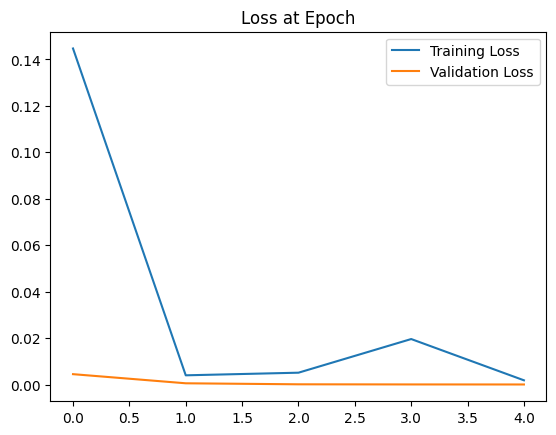

In [16]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

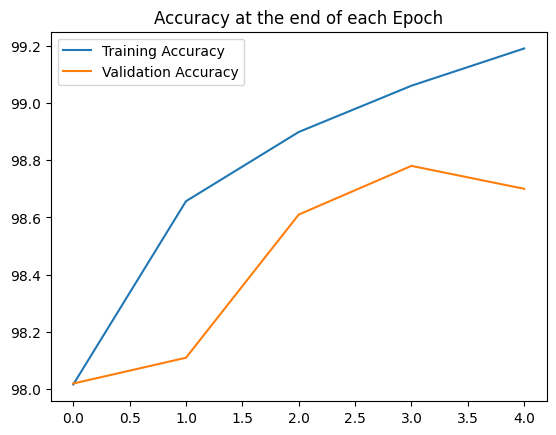

In [17]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [18]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False) #

with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

# Did for correct
print(correct.item()/len(test_data)*100)

98.7


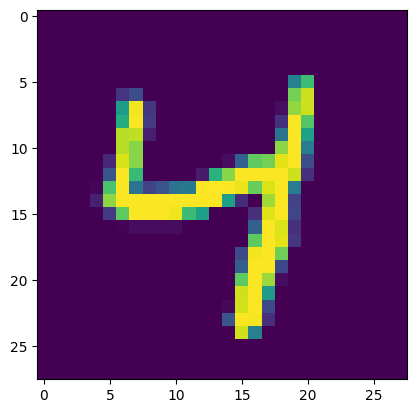

In [19]:
# Grab a random image: Tensor with an image in it...at end, it shows the image-number (data, label)
test_data[1978]

# Grab just the data: (1, 28, 28), grey scale and x*y
test_data[1978][0]

# Reshape it. We are allowed to do so, because the intensity values are already captured in the (28, 28) structure. So the extra "1" in 3rd dimention is unnessisary
# A grayscale image is represented by a single intensity value for each pixel, which is stored in a 2D grid of size 28x28.
test_data[1978][0].reshape(28,28)

# Show the image
plt.imshow(test_data[1978][0].reshape(28,28)) #BOOOOMBACLAAAAAT

In [21]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1978][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

In [23]:
# Check the new prediction...get probabilities
print(new_prediction)

print(new_prediction.argmax()) #

tensor([[-2.6150e+01, -1.7828e+01, -2.2572e+01, -2.3401e+01, -4.7684e-07,
         -2.3021e+01, -1.5780e+01, -1.6879e+01, -1.8759e+01, -1.4971e+01]])
tensor(4)
